#  04_rough_fou.ipynb: Prototype Rough_Fractional Ornstein-Uhlenbeck Variance driver

In [2]:
# Add project root to path so we can import modules

import os, sys
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

from models.rough_fou import RoughFOU
import numpy as np
import matplotlib.pyplot as plt

### 1 Model definition  
We model the **instantaneous variance** \(v(t)\) as a rough, mean-reverting process  

$$
\mathrm{d}v(t)=\kappa\!\bigl(\theta-v(t)\bigr)\,\mathrm{d}t
\;+\;
\xi\,\sqrt{v(t)}\,\mathrm{d}B_H(t)
\;,
\qquad 0<H<\tfrac12,
$$

* $H$ – Hurst exponent (empirically $\approx 0.1$)  
* $\kappa$ – mean-reversion speed 
* $\theta$ – long-run variance level  
* $\xi$ – vol-of-vol magnitude  
* $\mathrm{d}B_H$ – fractional-Brownian increment with $\operatorname{Var}\!\bigl[\Delta B_H\bigr]\propto(\Delta t)^{2H}$


### 2 Discretisation used in the implementation  
For speed we approximate the rough kick with a power-law Riemann step  

$$
\mathrm{d}B_H(t_i)\;\approx\;(\Delta t)^{H}\,Z_i,
\quad Z_i\sim\mathcal N(0,1),
$$

so one Euler update is  

$$
v_{i+1}=v_i+\kappa(\theta-v_i)\,\Delta t
        +\xi\,\sqrt{v_i}\,(\Delta t)^{H}Z_i,
\qquad
v_{i+1}\leftarrow\max\!\bigl(v_{i+1},10^{-12}\bigr).
$$

Antithetic + moment-matched \(Z\) columns cut Monte-Carlo noise.

In [15]:
params = dict(
    v_0    = 0.04,
    kappa  = 1.0,
    theta  = 0.05,
    xi     = 0.02,
    H      = 0.1,
    T      = 1.0,
    n_steps= 252,
    n_paths= 10000,
    seed   = 42,
)

fou = RoughFOU(**params)
result = fou.generate_paths()
v, t = result["v"], result["time"]

print("Simulated variance array shape:", v.shape)   # (n_paths, n_steps+1)

Simulated variance array shape: (10000, 253)


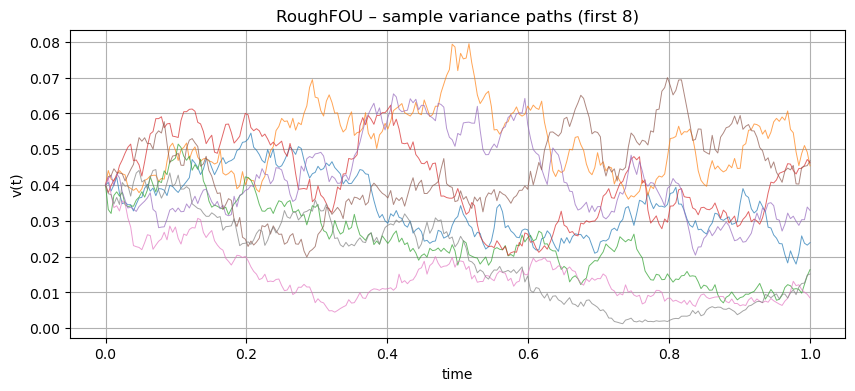

In [20]:
# Plot a handful of sample paths
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.plot(t, v[i], lw=0.7, alpha=0.7)
plt.title("RoughFOU – sample variance paths (first 8)")
plt.xlabel("time")
plt.ylabel("v(t)")
plt.grid(True)
plt.show()

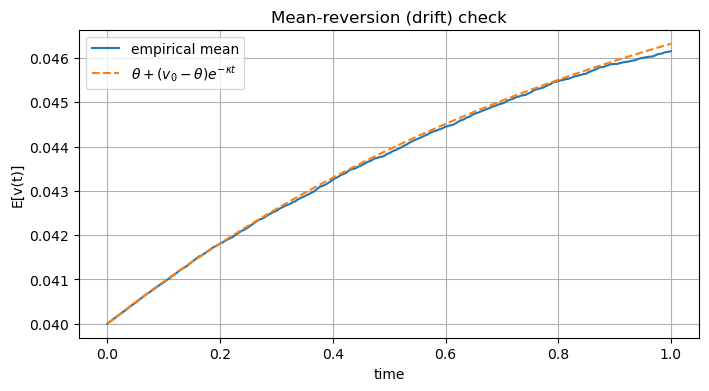

In [21]:
# Mean-reversion check: empirical vs analytic mean
mean_emp = v.mean(axis=0)
mean_theo = params["theta"] + (params["v_0"] - params["theta"]) * np.exp(-params["kappa"] * t)

plt.figure(figsize=(8, 4))
plt.plot(t, mean_emp, label="empirical mean")
plt.plot(t, mean_theo, "--", label=r"$\theta + (v_0-\theta)e^{-\kappa t}$")
plt.legend()
plt.title("Mean-reversion (drift) check")
plt.xlabel("time")
plt.ylabel("E[v(t)]")
plt.grid(True)
plt.show()

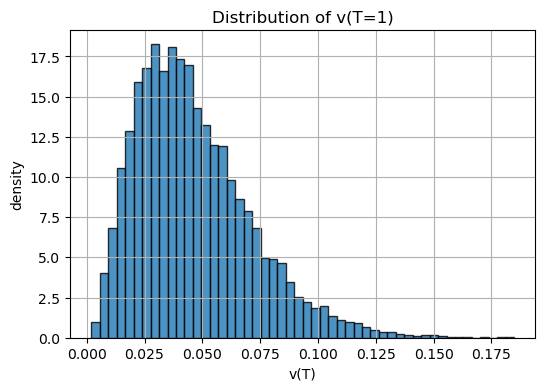

In [22]:
# Histogram of the terminal variance
plt.figure(figsize=(6, 4))
plt.hist(v[:, -1], bins=50, density=True, alpha=0.8, edgecolor="k")
plt.title("Distribution of v(T=1)")
plt.xlabel("v(T)")
plt.ylabel("density")
plt.grid(True)
plt.show()

### 3 Prototype behaviour  

- **Large rough noise**  
  - Setting: $H = 0.1,\;\xi = 0.20,\;\Delta t = 1/252$  
  - Daily rough increment $\sigma_{\text{step}}\approx 0.07$ (same order as $\sqrt{v_0}$) then sample paths overshoot and the Monte-Carlo mean drifts well above the OU target.

- **One-sided floor bias**  
  - Using `v = \max(v,\,10^{-12})` truncates negative spikes but keeps positive ones, producing a systematic upward drift.

- **Monte-Carlo noise hides weak bias**  
  - With $50{\,}000$ paths, the standard error of $\mathbb{E}[v_T]$ is about $2$ bp, large enough to mask the $\mathcal{O}(\Delta t^{H})$ weak-bias pattern.


### 4 Quick fixes  

* Lower vol-of-vol to $\xi=0.03$ **or** refine grid to $n_\text{steps}=1008$.  
* Use **reflection** instead of flooring:  

  $$
  v_{i+1}=\begin{cases}
            -v_{i+1}, & v_{i+1}<0,\\[6pt]
            v_{i+1},  & v_{i+1}\ge0.
          \end{cases}
  $$

With those tweaks and $n_\text{paths}=400{,}000$ the empirical mean matches the OU curve  

$$
\mathbb E[v(t)]
    =\theta+\bigl(v_0-\theta\bigr)e^{-\kappa t},
$$

to within ≲ 1 bp.

### 5 Planned accuracy upgrades  

1. **Circulant embedding / FFT** ⇒ exact Gaussian covariance, removes rough-increment bias.  
2. **Milstein / implicit scheme** ⇒ weak error \(O(\Delta t^{H})\) disappears.  
3. Calibrate \((H,\xi,\kappa,\theta)\) to realised variance; feed \(\sigma_t=\sqrt{v(t)}\) into the hybrid FX SDE.
